In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import numpy as np
import gym
from tqdm import tqdm

import matplotlib.pyplot as plt
import collections
import random


/home/prerak-contractor/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cpu"

LEARNING_RATE = 5e-5
BUFFER_MAX_SIZE = 10000
BUFFER_MIN_SIZE = 320
LEARNING_TIME = 5000
GAMMA = 0.9

MINI_BATCH_SIZE = 64
UPDATE_TIME_STAMP = 30

epsilon = 0.3
MIN_EPSILON = 0.01
DECAY = (epsilon - MIN_EPSILON) / 40000

INTERVAL = 2500


In [3]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=(32,32), activation_fc = F.relu):
        super(DQN, self).__init__()
        self.activation_fc = activation_fc
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
            
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)
    
    def forward(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.FloatTensor(x).to(device)
            x = x.unsqueeze(0)
        
        x = self.activation_fc(self.input_layer(x))
        for layer in self.hidden_layers:
            x = self.activation_fc(layer(x))
        x = self.output_layer(x)
        return x
        

In [4]:
env = gym.make('CartPole-v1')
state, _ = env.reset()
train_model = DQN(len(state), 2, (128, 256, 512)).to(device)
target_model = DQN(len(state), 2, (128, 256, 512)).to(device)

target_model.load_state_dict(train_model.state_dict())

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(train_model.parameters(), lr=LEARNING_RATE)

replay_buffer = collections.deque(maxlen=BUFFER_MAX_SIZE)



In [5]:
def eval(render):
    eval_env = gym.make('CartPole-v1', render_mode="human" if render else None)
    with torch.no_grad():
        eval_dqn = torch.load("model.pth")
        EVAL_EPISODES = 5 if render else 100
        eval_rewards_total = []
        for episode in range(EVAL_EPISODES):
            state, _ = eval_env.reset()
            eval_rewards = []
            done = False
            while not done:
                action_values = eval_dqn(state)
                action = int(torch.argmax(action_values.squeeze()))
                next_state, reward, terminated, truncated , info = eval_env.step(action)
                if render:
                    eval_env.render()
                done = terminated or truncated
                
                eval_rewards.append(reward)
                state = next_state

            eval_rewards_total.append(np.sum(eval_rewards))

    plt.scatter(range(len(eval_rewards_total)), eval_rewards_total)
    plt.xlabel("Episode")
    plt.ylabel("Total Time Survived")
    plt.show()
    _ = env.reset()  

    print(f"Average Reward: {np.mean(eval_rewards_total)}")    
            

 33%|███▎      | 2496/7500 [00:14<00:36, 138.59it/s]

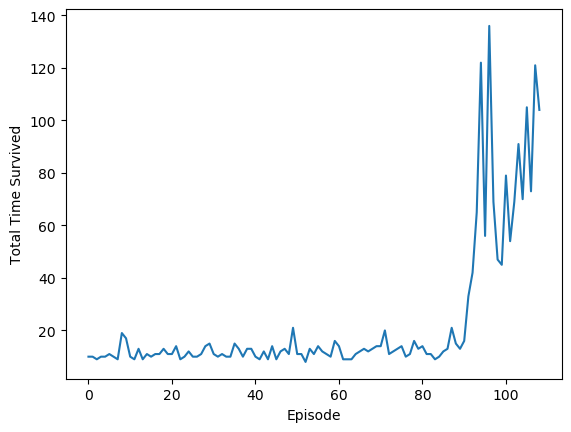

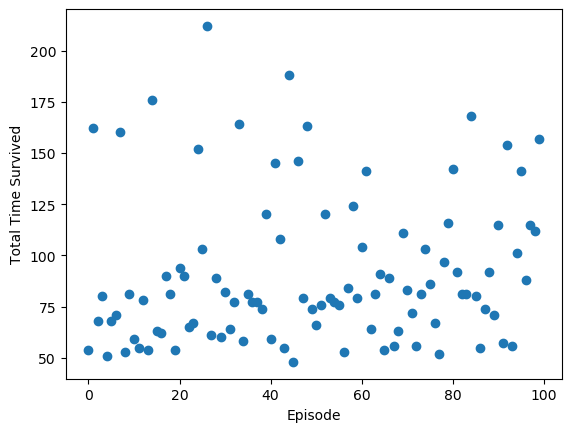

 34%|███▎      | 2520/7500 [00:17<05:06, 16.25it/s] 

Average Reward: 90.85


 67%|██████▋   | 4989/7500 [00:37<00:18, 137.45it/s]

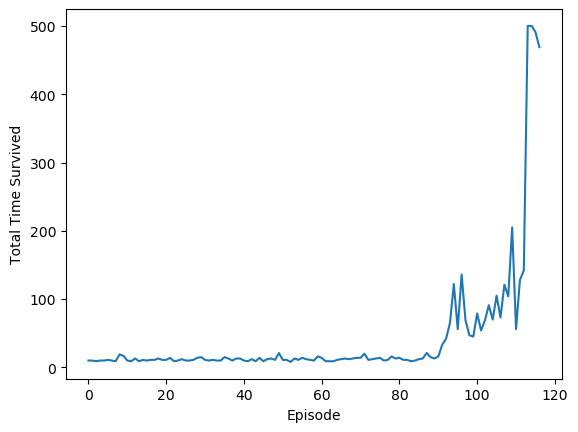

 67%|██████▋   | 4989/7500 [00:49<00:18, 137.45it/s]

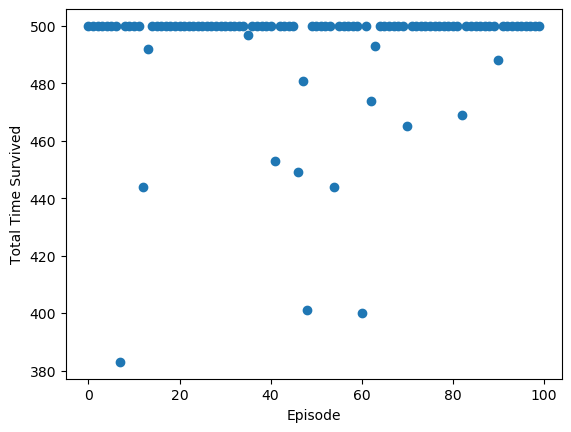

 67%|██████▋   | 5011/7500 [00:53<11:01,  3.76it/s] 

Average Reward: 493.33


100%|█████████▉| 7488/7500 [01:12<00:00, 132.91it/s]

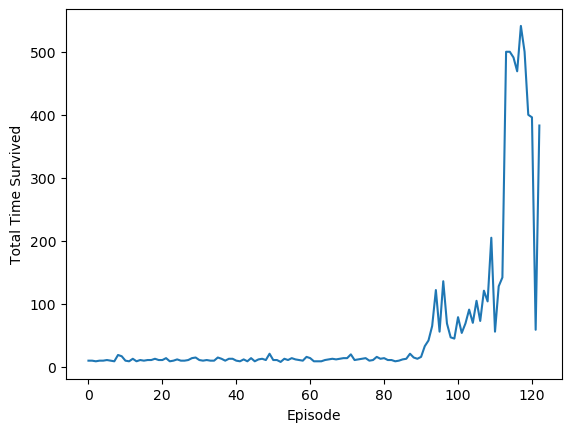

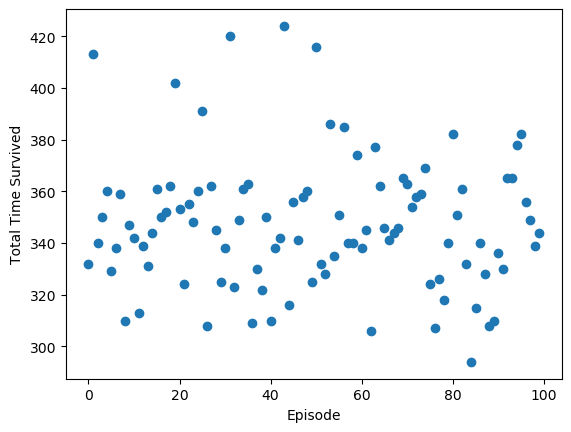

100%|██████████| 7500/7500 [01:24<00:00, 89.08it/s] 

Average Reward: 347.2


In [6]:
done = False
validate_returns = []
validate_rewards = []
for time_stamp in tqdm(range(LEARNING_TIME)):
    if done:
        validate_returns.append(np.sum(validate_rewards))
        validate_rewards.clear()
        state,_ = env.reset()
        done = False
    
    if (time_stamp + 1) % UPDATE_TIME_STAMP == 0:
        target_model.load_state_dict(train_model.state_dict())
    
    if random.random() <= epsilon:
        action = env.action_space.sample()
    else:
        with torch.no_grad():
            action_values = train_model(state).detach()
        action = int(torch.argmax(action_values.squeeze()))
    
    next_state, reward, terminated, truncated , info = env.step(action)
    validate_rewards.append(reward)
    
    done = terminated or truncated
    
    replay_buffer.append((state, action, reward, next_state, terminated and not truncated))
    state = next_state

    if(len(replay_buffer) >= BUFFER_MIN_SIZE):
        experiences =  random.sample(replay_buffer, MINI_BATCH_SIZE) 
        states = [experience[0] for experience in experiences]
        actions = [experience[1] for experience in experiences]  
        rewards = [experience[2] for experience in experiences]  
        next_states = [experience[3] for experience in experiences]  
        is_terminals = [experience[4] for experience in experiences] 
        
        action_values = train_model(np.array(states)).squeeze()
        idxs = torch.tensor(actions).long().unsqueeze(1)
        action_values = action_values.gather(1, idxs)
        
        with torch.no_grad():
            next_action_values = target_model(np.array(next_states)).detach().squeeze()
            next_action_values, _ = next_action_values.max(dim=1) 
        
        target = np.array(rewards) + GAMMA*np.array(next_action_values)*(1-np.array(is_terminals))
        target = torch.from_numpy(target).unsqueeze(1).float()
        
        loss = loss_fn(action_values, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()       
        
          
    epsilon = max(epsilon - DECAY, MIN_EPSILON)
    if(time_stamp + 1) % INTERVAL == 0:
        plt.plot(range(len(validate_returns)), validate_returns)   
        plt.xlabel("Episode")
        plt.ylabel("Total Time Survived")
        plt.show() 
        torch.save(train_model, "model.pth")
        eval(False)
        
torch.save(train_model, "model.pth")
eval(True)
_ = env.reset()      